In [1]:
from adadamp import DaskBaseDamper

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

DaskBaseDamper works with Torch dataset:

In [3]:
class Net(nn.Module):
    def __init__(self, n_features=20, n_outputs=1, hidden=40):
        super(Net, self).__init__()

        self.hidden = hidden
        self.n_features = n_features
        self.n_outputs = n_outputs

        self.fc1 = nn.Linear(self.n_features, self.hidden)
        self.fc2 = nn.Linear(self.hidden, self.n_outputs)

    def forward(self, x):
        x = x.float()  # type casting to make sure works well with sklearn
        y = F.relu(self.fc1(x))
        y = self.fc2(y)
        return y

In [4]:
from sklearn.datasets import make_regression
X, y = make_regression(random_state=42, n_features=20, n_samples=1000, noise=1)
X, y = X.astype("float32"), y.astype("float32")
y *= 0.9
y -= 0.1

In [5]:
X_torch = torch.from_numpy(X)
y_torch = torch.from_numpy(y)
dataset = torch.utils.data.TensorDataset(X_torch, y_torch)

net = DaskBaseDamper(
    module=Net, loss=nn.MSELoss, optimizer=optim.SGD, optimizer__lr=0.001, batch_size=64
)
net.get_params()

{'module': __main__.Net,
 'loss': torch.nn.modules.loss.MSELoss,
 'optimizer': torch.optim.sgd.SGD,
 'metrics': None,
 'device': 'cpu',
 'batch_size': 64,
 'max_batch_size': 1024,
 'min_workers': 1,
 'max_workers': 8,
 'optimizer__lr': 0.001}

In [6]:
import numpy.linalg as LA
data = []
for k in range(10):
    _ = net.fit(dataset);
    score = net.score(X, y)
    norm = sum([LA.norm(x.detach().numpy()) for x in net.module_.parameters()])
    datum = {"score": score, "norm": norm, **net.meta_}
    data.append(datum)

In [7]:
import pandas as pd
df = pd.DataFrame(data)
df.head()

,score,norm,n_updates,n_data
0,10403.5850,34.413129,32,1024
1,8381.1535,35.751680,64,2048
2,8037.4040,35.985588,96,3072
3,7928.1510,36.054038,128,4096
4,7881.8495,36.082407,160,5120


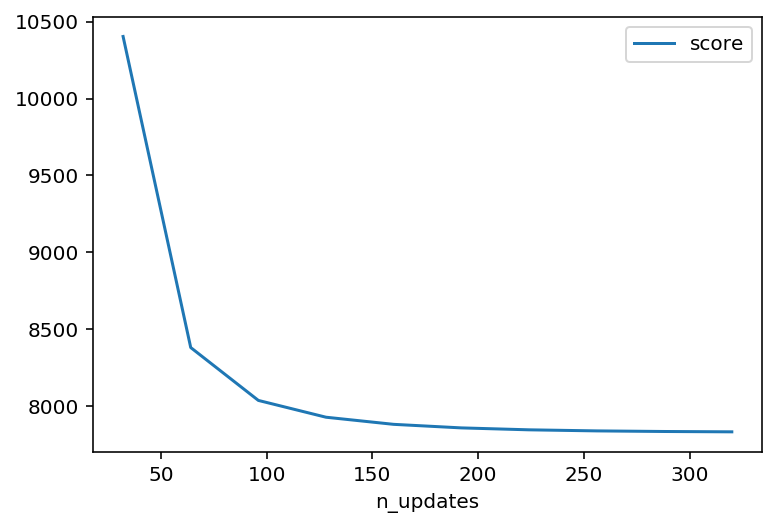

In [8]:
df.plot(x="n_updates", y="score")

In [9]:
net.score(X, y)

7833.1405

It also works with NumPy data:

In [10]:
net = DaskBaseDamper(
    module=Net, loss=nn.MSELoss, optimizer=optim.SGD, optimizer__lr=0.002,
)
net.fit(X, y)

In [11]:
net.score(X, y)

8360.179